<a href="https://colab.research.google.com/github/MarcoParola/structural_health_monitoring/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Link Drive, import packages and declare global variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix

projectPath = 'drive/MyDrive/Colab Notebooks/thesis2/'

NUMBER_OF_CLASS = 9
TRUNCATE = 9000

filter_indeces = [1,5,9,12,14,15]

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/.shortcut-targets-by-id/1RdMs44loEcFGBtBOenib5G7znvrr04KT/thesis2
/content


Load and scale data

In [ ]:
data = np.load(DATASET)

labels = load_dataset('damage_labels')
levels = load_dataset('damage_levels')

randomize = np.arange(len(labels))
np.random.shuffle(randomize)
data = data[randomize,:,:]
labels = labels[randomize]
levels = levels[randomize]

dataset = data[0:TRUNCATE, 11:len(data[0])-12, :]
testset = data[TRUNCATE:len(data),  11:len(data[0])-12, :]

labels_train = labels[0:TRUNCATE]
levels_train = levels[0:TRUNCATE]
labels_test = labels[TRUNCATE:len(labels)]
levels_test = levels[TRUNCATE:len(levels)]

labels_train = to_categorical(labels_train)
labels_test = to_categorical(labels_test)

print(dataset.shape, testset.shape)

# max-min scale
for i in range(6):
  scale = 0
  if np.abs(np.min(dataset[:,:,i])) > np.max(dataset[:,:,i]):
    scale = np.abs(np.min(dataset[:,:,i]))
  else:
    scale = np.max(dataset[:,:,i])
  dataset[:,:,i] = dataset[:,:,i] / scale
  testset[:,:,i] = testset[:,:,i] / scale

# flat dataset
dataset = np.moveaxis(dataset, -1, 0)
testset = np.moveaxis(testset, -1, 0)
dataset = np.reshape(dataset, (len(dataset) * len(dataset[0]), len(dataset[0][0]) ))
testset = np.reshape(testset, (len(testset) * len(testset[0]), len(testset[0][0]) ))
print(dataset.shape, testset.shape)

(9999,)
(9999,)
(9000, 1728, 6) (999, 1728, 6)
(54000, 1728) (5994, 1728)


In [ ]:
# function to graphically compare an original signal with a reconstructed one

def plot_signals(model, original_signals, n=10, lstm=False):
  plt.rcParams["figure.figsize"] = (12,9)
  font = {'size'   : 14.5}
  plt.rc('font', **font)
  pred = model.predict(original_signals)

  if lstm:
    pred = pred.squeeze()
    original_signals = original_signals.squeeze()

  for i in range(10):
    print(i)
    plt.plot(original_signals[i], alpha=.4, label="Non-corrupted signal")
    plt.plot(pred[i], alpha=.5, label="Reconstructed signal")
    plt.legend(loc="upper right", prop={'size': 17})
    plt.show()

In [ ]:
# the function simulates the phenomenon of packet loss on the data given as parameters

def corrupt_signals(dataset, testset):
  MAX_PACKET_LOST = 5

  d = dataset.copy()
  for i in range(len(dataset)):
    pack_lost = np.random.randint(2, MAX_PACKET_LOST)
    indexes = np.random.randint(0, (int(len(dataset[0]) - 400 ) / 30), pack_lost )
    for k in indexes:
      for j in range(30):
        d[i,200 + (k*30) + j] = 0

  t = testset.copy()
  for i in range(len(testset)):
    pack_lost = np.random.randint(2, MAX_PACKET_LOST)
    indexes = np.random.randint(0, (int(len(testset[0]) - 400) / 30), pack_lost )
    for k in indexes:
      for j in range(30):
        t[i,200 + (k*30) + j] = 0

  return d, t

# **AUTOENCODER**

## Feedforward Autoencoder (FFAE)

In [ ]:
d = dataset.copy()
t = testset.copy()

# encoder
input_signal = keras.Input(shape=(len(dataset[0]),))
encoded = layers.Dense(256, activation='relu')(input_signal)
encoded = layers.Dense(70, activation='relu')(encoded)
encoder = keras.Model(input_signal, encoded, name='encoder')

#decoder
decoder_inputs = keras.Input(shape=(70,), name='decoded')
decoded = layers.Dense(70, activation='relu')(decoder_inputs)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(len(dataset[0]), activation='tanh')(decoded)
decoder = keras.Model(decoder_inputs, decoded, name='decoder')

outputs = decoder(encoder(input_signal))
ffae = keras.Model(input_signal, outputs)
ffae.summary()

ffae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = ffae.fit(d, d, epochs=25, callbacks=[earlyStopCallback], batch_size=64, shuffle=True, validation_split=0.2)
evaluate_autoencoder(ffae, t)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1728)]            0         
                                                                 
 encoder (Functional)        (None, 70)                460614    
                                                                 
 decoder (Functional)        (None, 1728)              467242    
                                                                 
Total params: 927,856
Trainable params: 927,856
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
675/675 [==============================] - 5s 4ms/step - loss: 0.0015 - accuracy: 0.2232 - val_loss: 0.0014 - val_accuracy: 0.1542
Epoch 2/25
675/675 [==============================] - 2s 4ms/step - loss: 6.2979e-04 - accuracy: 0.3477 - val_loss: 0.0013 - val_accuracy: 0.1819
Epoch 3/25
675/675 [===========

0


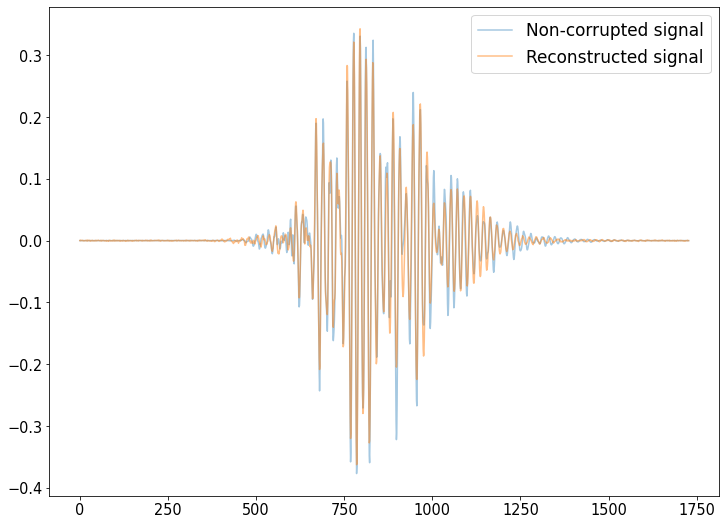

1


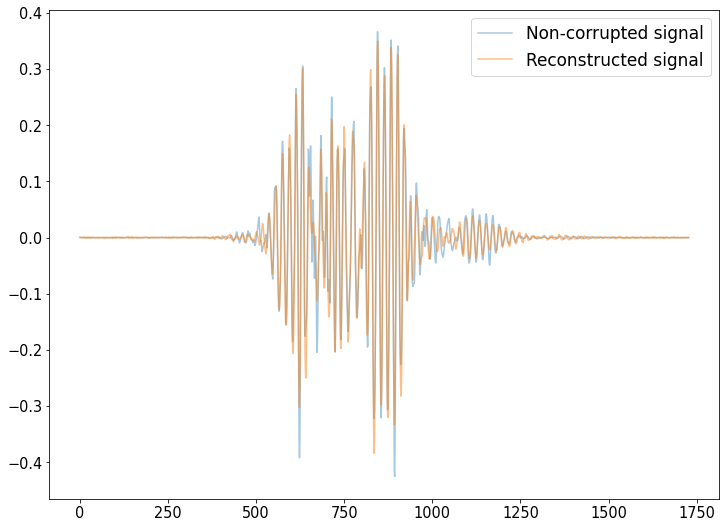

2


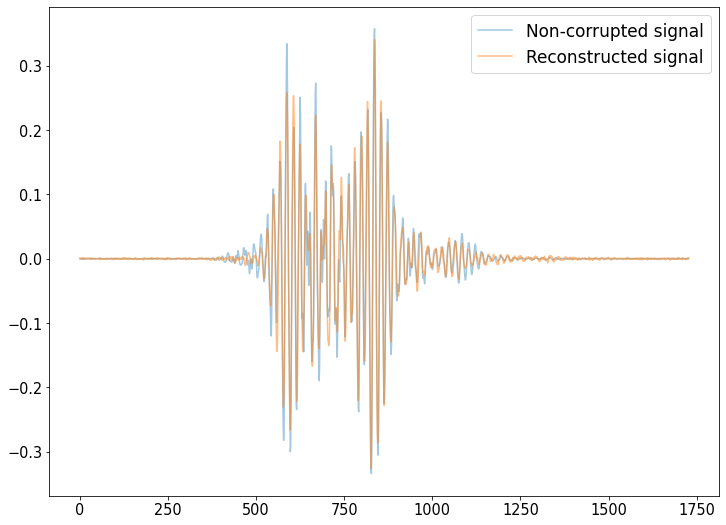

3


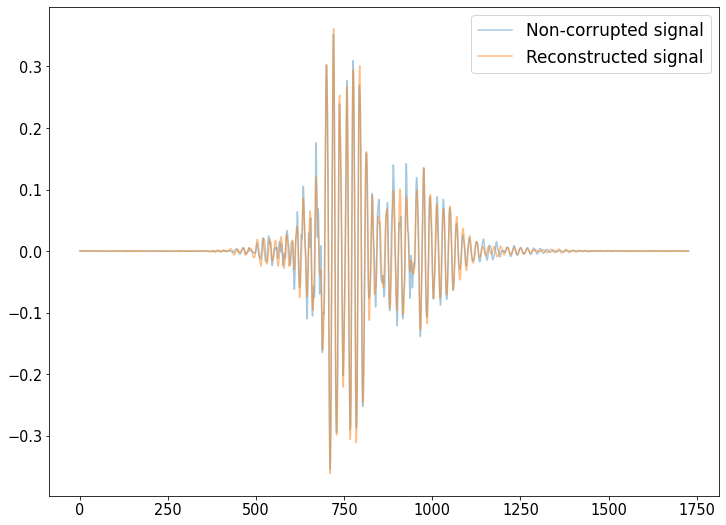

4


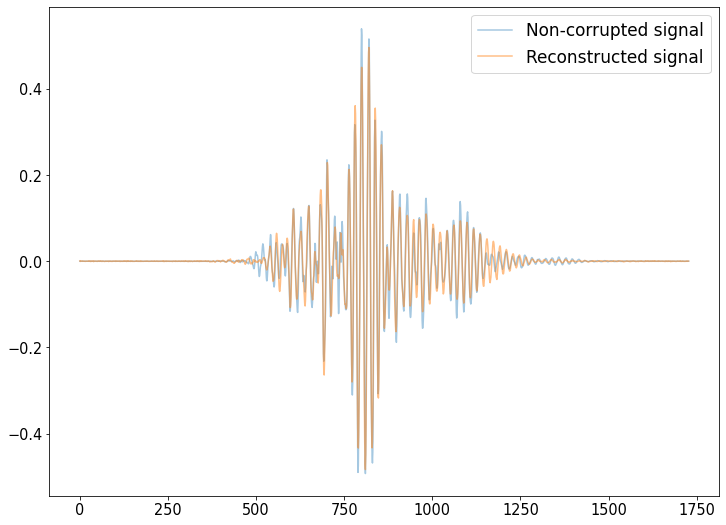

5


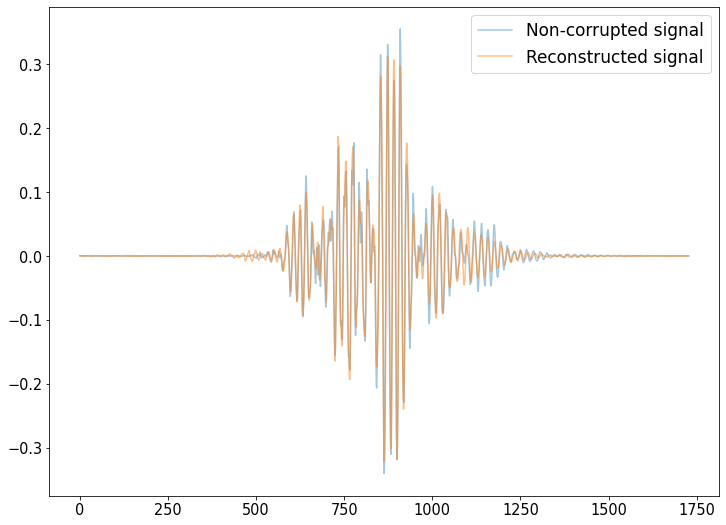

6


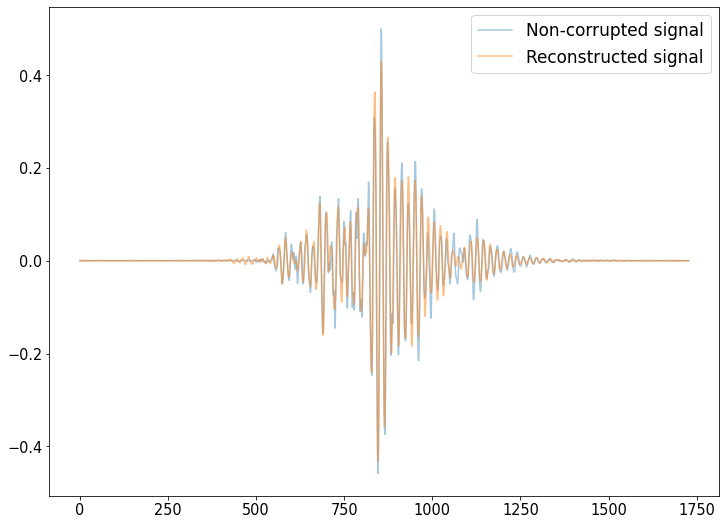

7


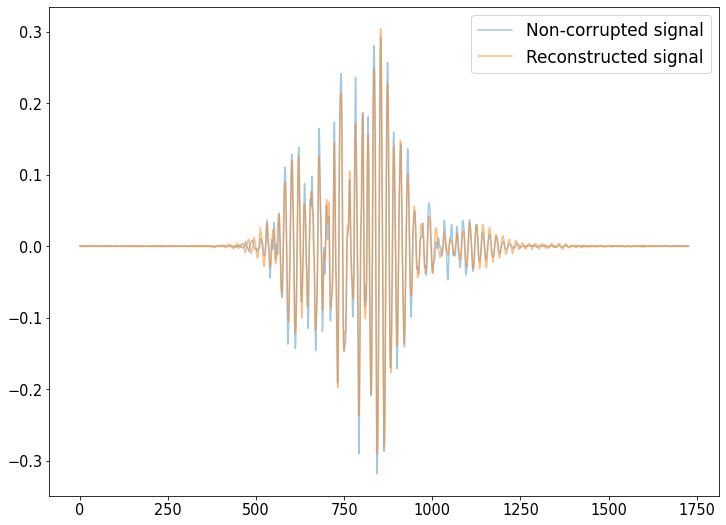

8


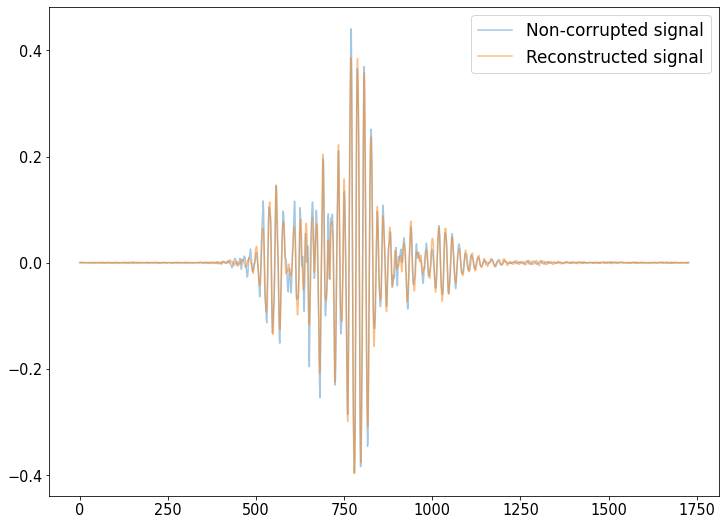

9


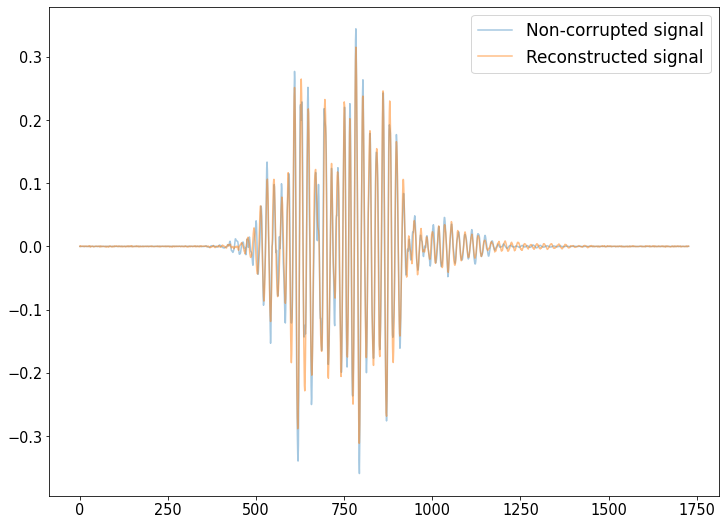

In [ ]:
plot_signals(ffae, testset, 12)

## Convolutional Autoencoder (CAE)

In [ ]:
d = dataset.copy()
t = testset.copy()

# encoder
input_signal = keras.Input(shape=(len(dataset[0]),1))
x = layers.Conv1D(1, 20, activation='tanh', padding='same')(input_signal)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(16, 8, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(6, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3, padding='same', name='last')(x)
encoded = layers.Flatten(name='encoer_flatted')(x)
encoder = keras.Model(input_signal, encoded, name='encoder')

# decoder 
decoder_inputs = keras.Input(shape=(encoded.shape[1]), name='encoded')
x = layers.Reshape((encoder.get_layer('last').output).shape[1:3], input_shape=x.shape[1:])(decoder_inputs)
x = layers.Conv1D(6, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(16, 8, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(1, 20, activation='tanh', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoder = keras.Model(decoder_inputs, x, name='decoder')

encoder.summary()
decoder.summary()

outputs = decoder(encoder(input_signal))
cae = keras.Model(input_signal, outputs)
cae.summary()

cae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = cae.fit(d, d, epochs=30, callbacks=[earlyStopCallback], batch_size=128, shuffle=True, validation_split=0.2)
evaluate_autoencoder(cae, np.reshape(t, (len(t), len(t[0]), 1)))

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1728, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1728, 1)           21        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 864, 1)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 864, 16)           208       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 288, 16)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 288, 16)           2064

0


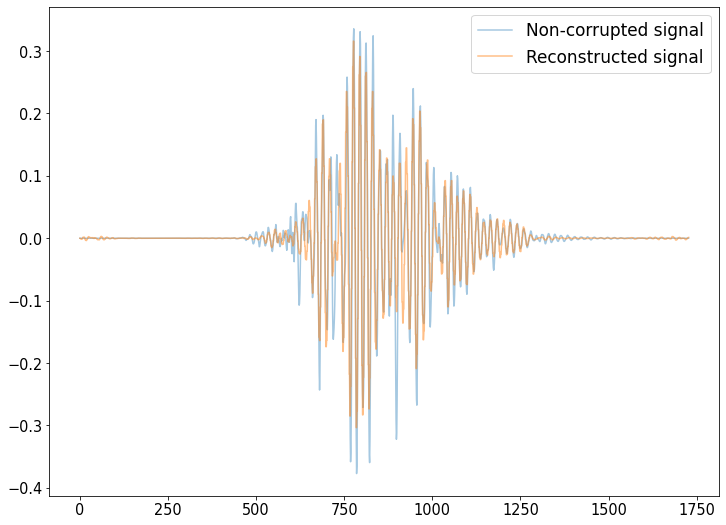

1


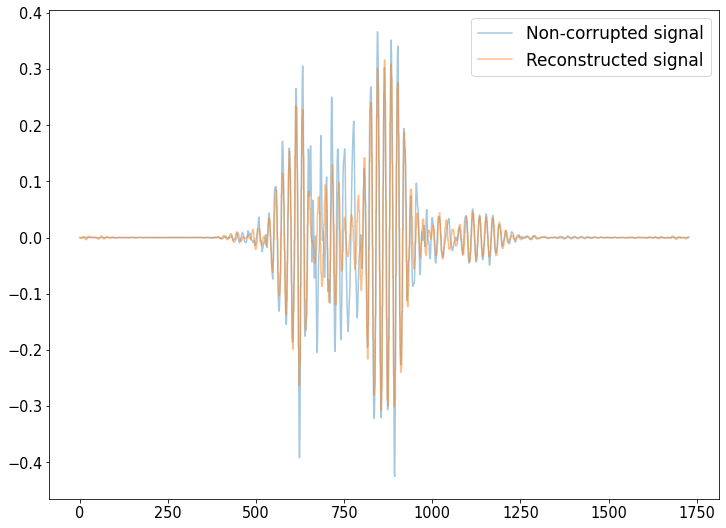

2


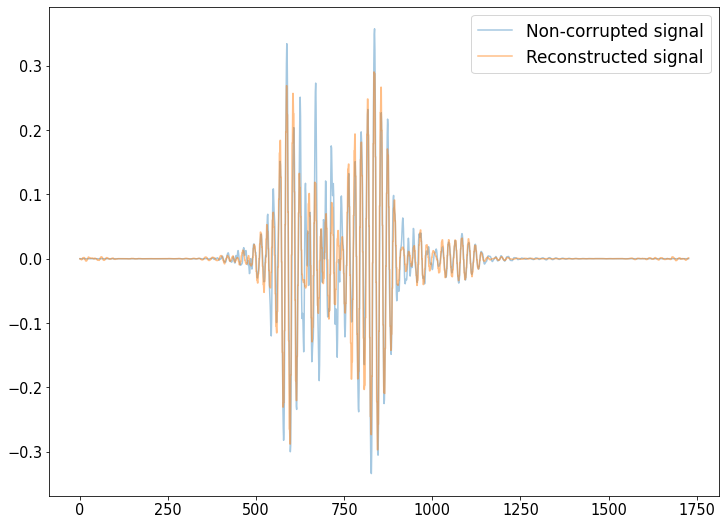

3


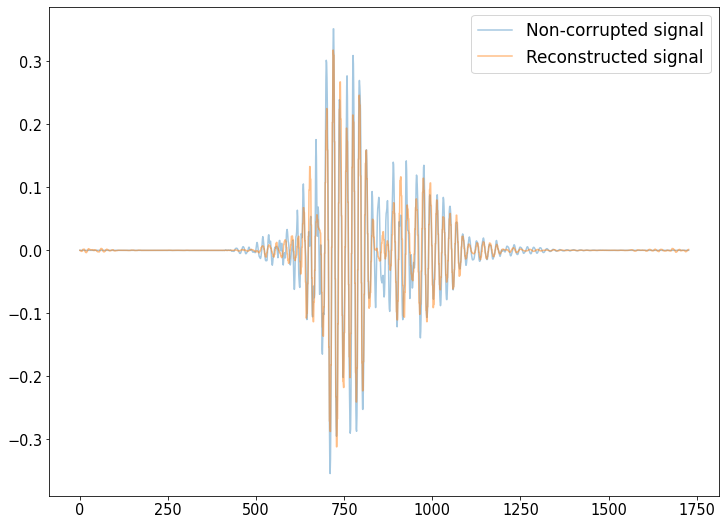

4


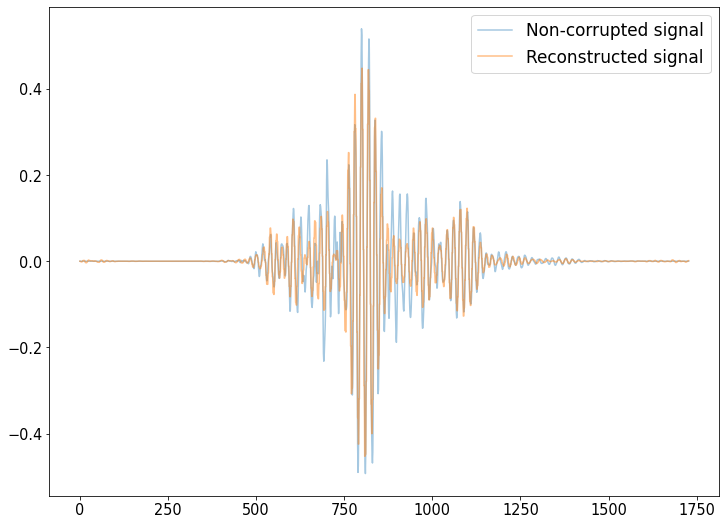

5


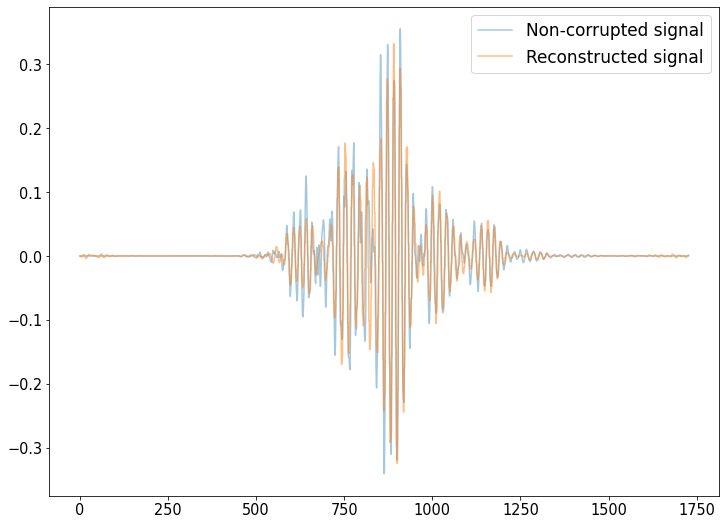

6


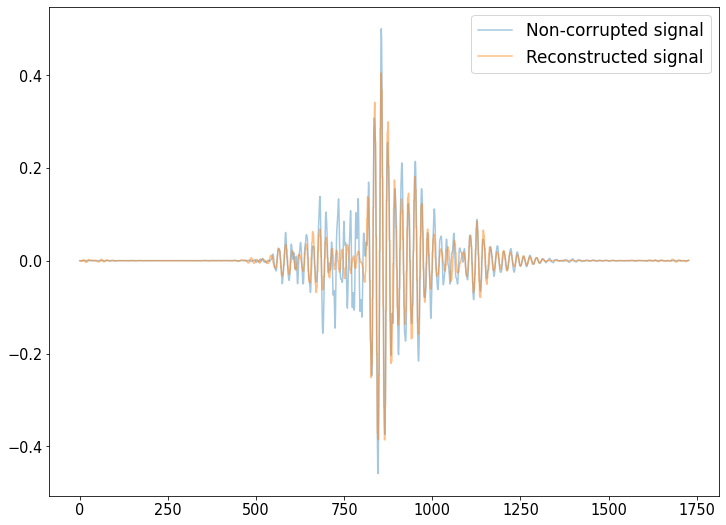

7


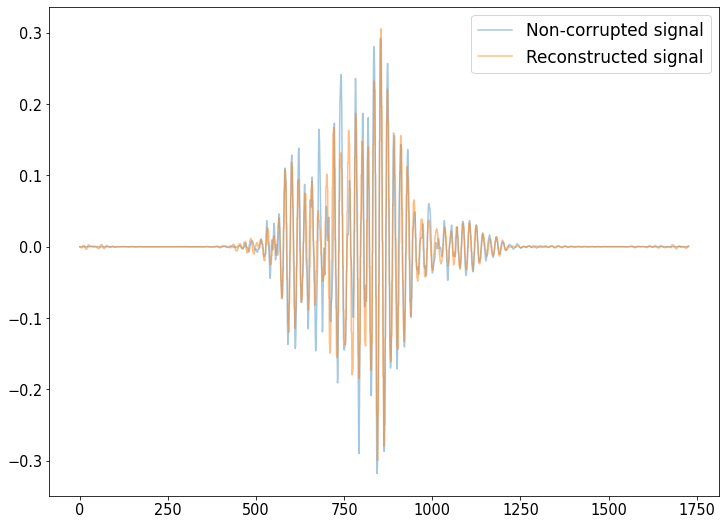

8


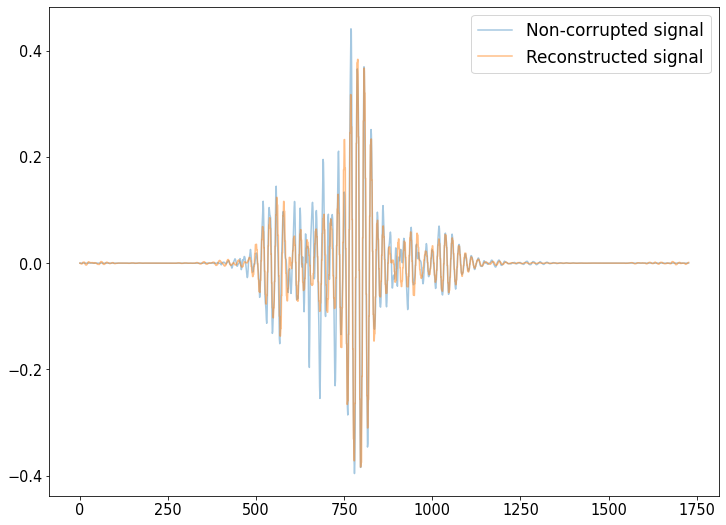

9


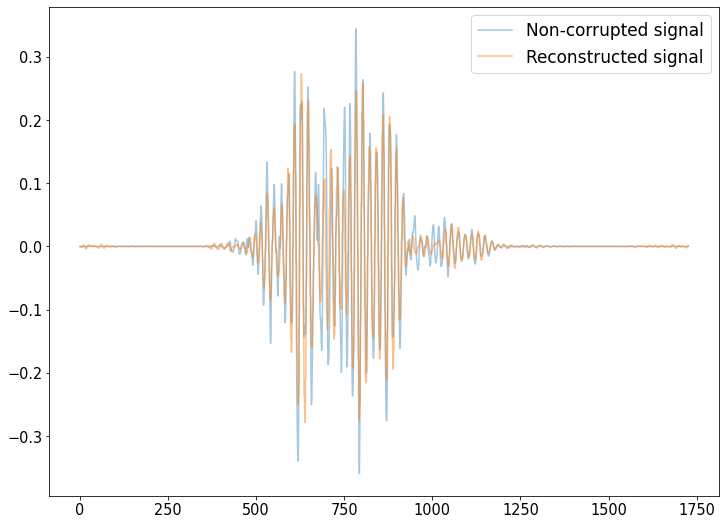

In [ ]:
plot_signals(cae, testset, 12)

## Long Short Time Memory Autoencoder (LSTMAE)

In [ ]:
#Dataset reshaping, in order to allow to lstm network to work on the data
d = dataset.copy()
t = testset.copy()
d = np.reshape(d, (len(d), 1, len(d[0])))
t = np.reshape(t, (len(t), 1, len(t[0])))
print(d.shape, t.shape)

(54000, 1, 1728) (5994, 1, 1728)


In [ ]:
window_size = 1

# encoder
input_signal = keras.Input(shape=(window_size, len(d[0][0])))
x = layers.LSTM(70, activation='tanh', input_shape=(window_size, len(d[0][0])), return_sequences=True)(input_signal)
encoder = keras.Model(input_signal, x, name='encoder')

#decoder
decoder_inputs = keras.Input(shape=(window_size, 70), name='decoded')
x = layers.LSTM(70, activation='tanh', input_shape=(window_size, len(d[0][0])), return_sequences=True)(decoder_inputs)
decoded = layers.TimeDistributed(layers.Dense(units=len(d[0][0])))(x)
decoder = keras.Model(decoder_inputs, decoded, name='decoder')

encoder.summary()
decoder.summary()

outputs = decoder(encoder(input_signal))
lstmae = keras.Model(input_signal, outputs)

lstmae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = lstmae.fit(d, d, epochs=25, callbacks=[earlyStopCallback], batch_size=256, shuffle=True, validation_split=0.2)
evaluate_autoencoder(lstmae, t)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1728)]         0         
                                                                 
 lstm (LSTM)                 (None, 1, 70)             503720    
                                                                 
Total params: 503,720
Trainable params: 503,720
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoded (InputLayer)        [(None, 1, 70)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 70)             39480     
                                                                 
 time_distributed (TimeDistr  (None,

0


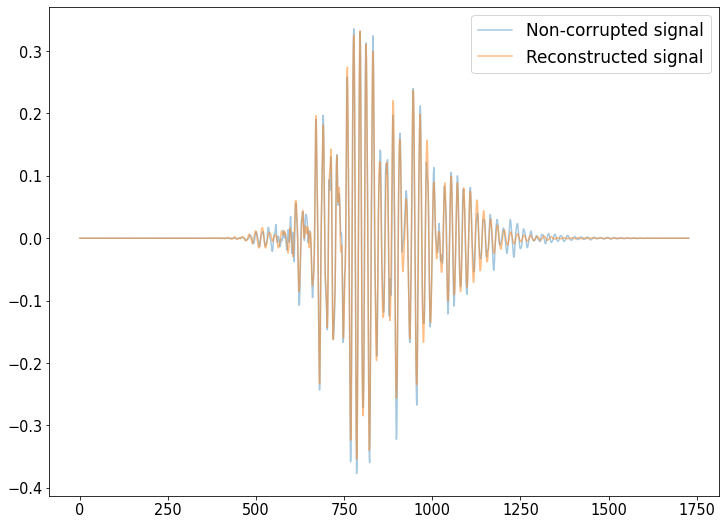

1


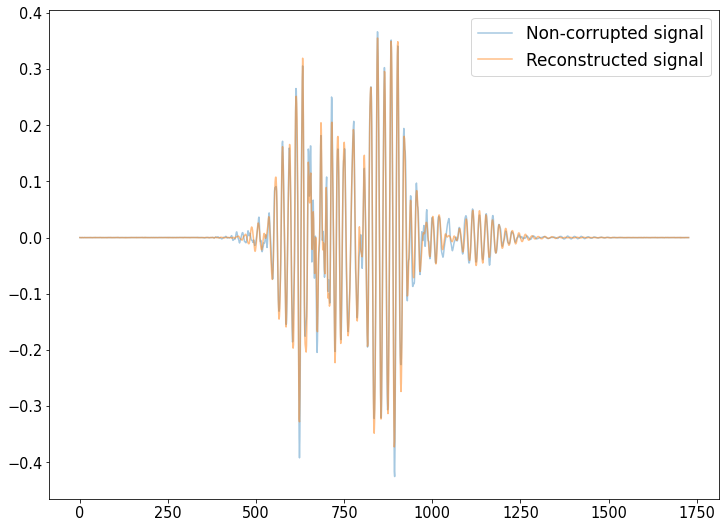

2


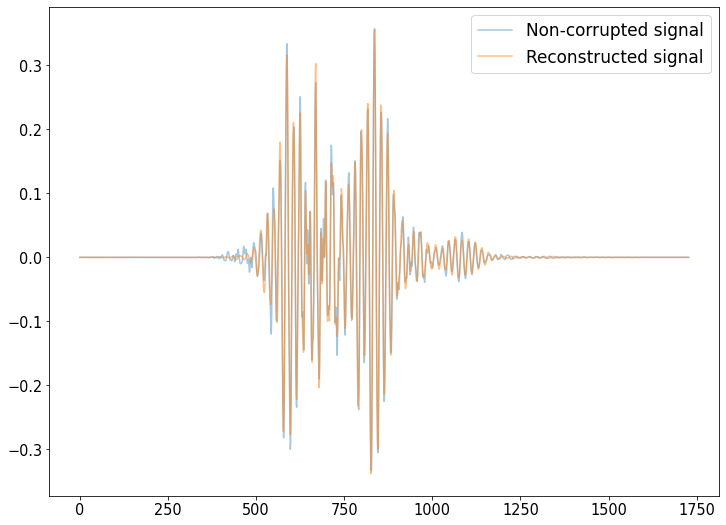

3


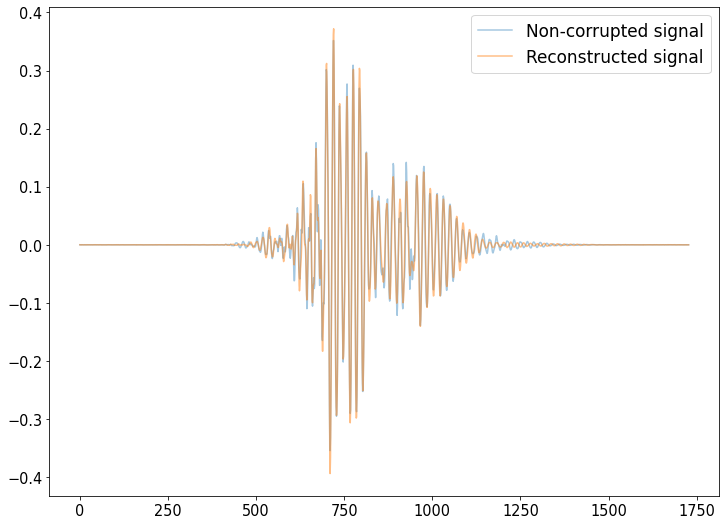

4


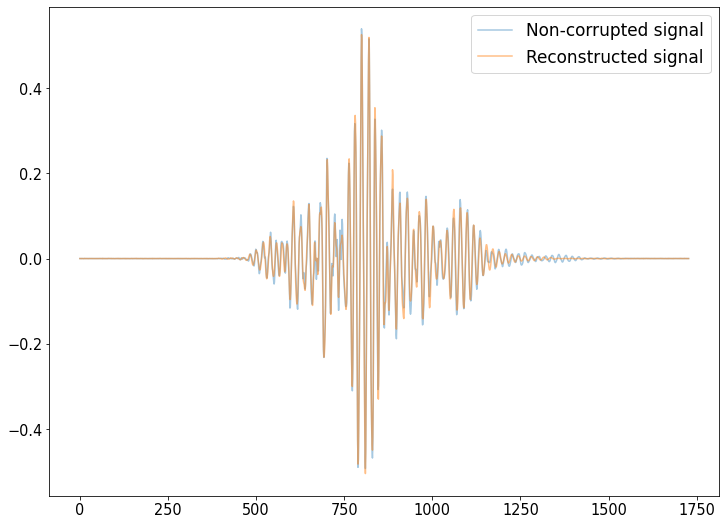

5


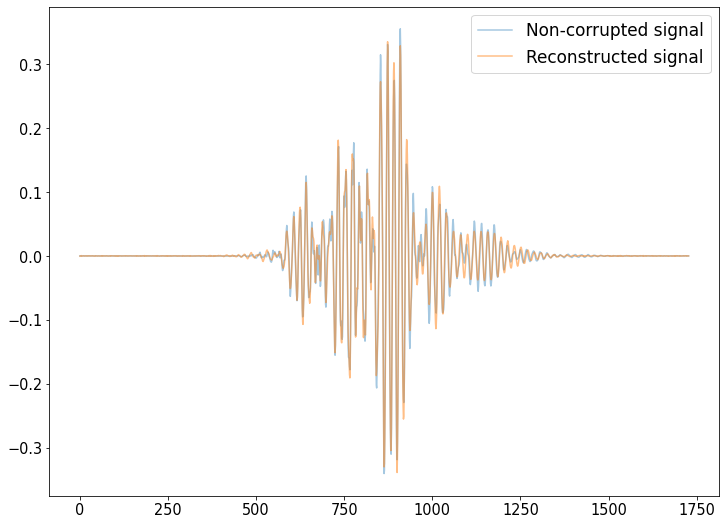

6


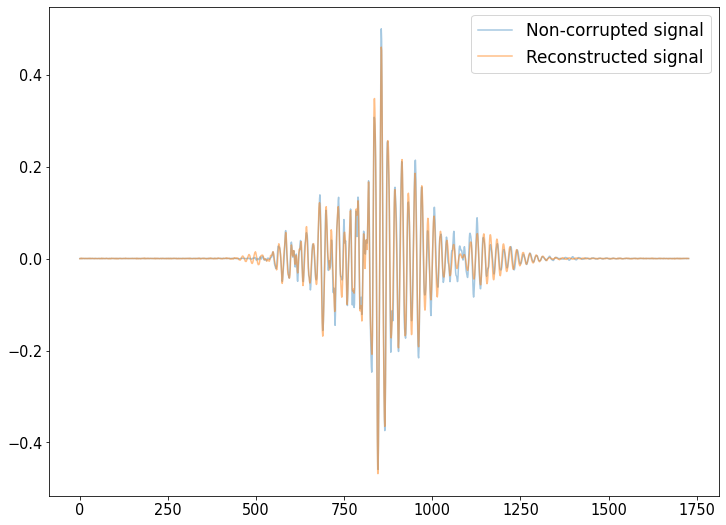

7


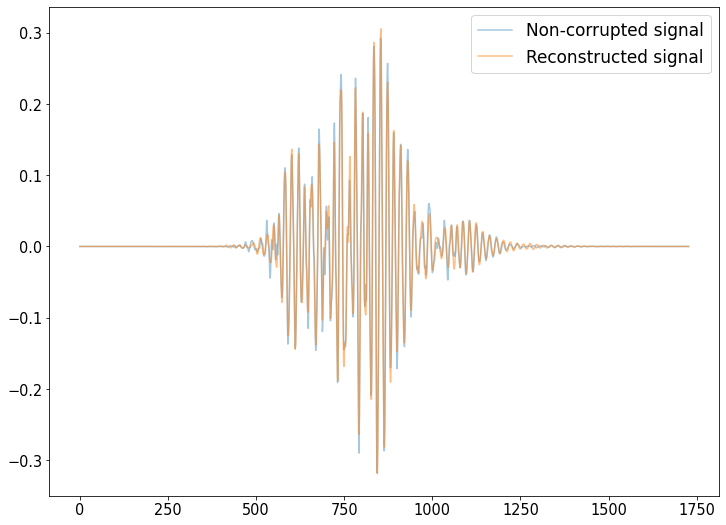

8


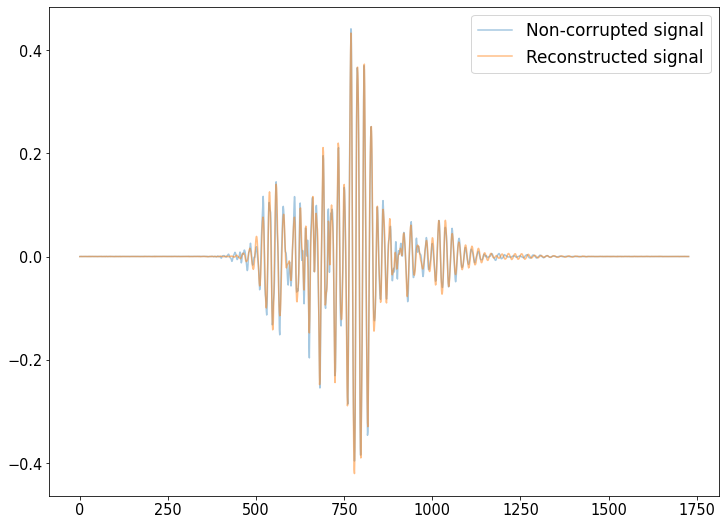

9


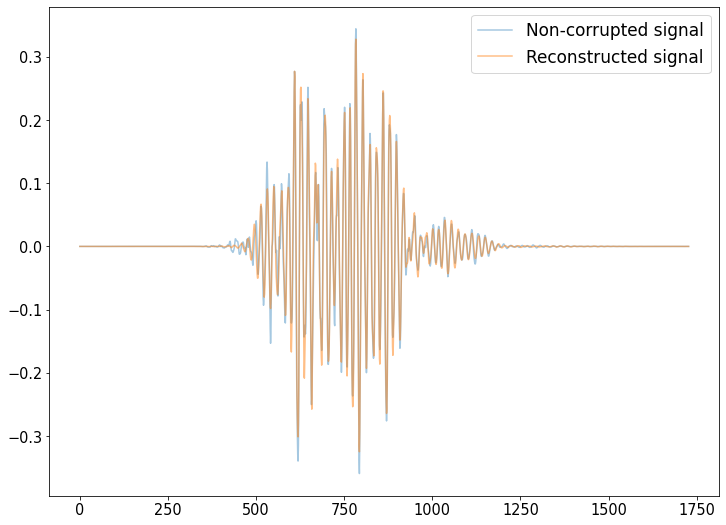

In [ ]:
plot_signals(lstmae, t, 12, True)

# **AUTOENCODER reconstruction**

## Reconstructive Feedforward Autoencoder (RFFAE)

In [ ]:
d,t = corrupt_signals(dataset, testset)

# encoder
input_signal = keras.Input(shape=(len(dataset[0]),))
encoded = layers.Dense(256, activation='relu')(input_signal)
encoded = layers.Dense(70, activation='tanh')(encoded)
encoder = keras.Model(input_signal, encoded, name='encoder')

decoder_inputs = keras.Input(shape=(70,), name='decoded')
decoded = layers.Dense(70, activation='relu')(decoder_inputs)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(len(dataset[0]), activation='tanh')(decoded)
decoder = keras.Model(decoder_inputs, decoded, name='decoder')

outputs = decoder(encoder(input_signal))
r_ffae = keras.Model(input_signal, outputs)
r_ffae.summary()

r_ffae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = r_ffae.fit(d, dataset, epochs=30, callbacks=[earlyStopCallback], batch_size=64, shuffle=True, validation_split=0.2)
evaluate_denoising_autoencoder(r_ffae, testset, t)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1728)]            0         
                                                                 
 encoder (Functional)        (None, 70)                460614    
                                                                 
 decoder (Functional)        (None, 1728)              467242    
                                                                 
Total params: 927,856
Trainable params: 927,856
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
675/675 [==============================] - 3s 4ms/step - loss: 0.0016 - accuracy: 0.1994 - val_loss: 0.0016 - val_accuracy: 0.1435
Epoch 2/30
675/675 [==============================] - 2s 4ms/step - loss: 8.9487e-04 - accuracy: 0.3029 - val_loss: 0.0015 - val_accuracy: 0.1619
Epoch 3/30
675/675 [=========

## Reconstructive Convolutional Autoencoder (RCAE)

In [ ]:
d,t = corrupt_signals(dataset, testset)

# encoder
input_signal = keras.Input(shape=(len(dataset[0]),1))
x = layers.Conv1D(1, 20, activation='tanh', padding='same')(input_signal)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(16, 8, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(6, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(3, padding='same', name='last')(x)
encoded = layers.Flatten(name='encoer_flatted')(x)
encoder = keras.Model(input_signal, encoded, name='encoder')

# decoder 
decoder_inputs = keras.Input(shape=(encoded.shape[1]), name='encoded')
x = layers.Reshape((encoder.get_layer('last').output).shape[1:3], input_shape=x.shape[1:])(decoder_inputs)
x = layers.Conv1D(6, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(16, 8, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(16, 12, activation='relu', padding='same')(x)
x = layers.UpSampling1D(3)(x)
x = layers.Conv1D(1, 20, activation='tanh', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoder = keras.Model(decoder_inputs, x, name='decoder')

encoder.summary()
decoder.summary()

outputs = decoder(encoder(input_signal))
r_cae = keras.Model(input_signal, outputs)
r_cae.summary()

r_cae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = r_cae.fit(d, dataset, epochs=30, callbacks=[earlyStopCallback], batch_size=128, shuffle=True, validation_split=0.2)
evaluate_denoising_autoencoder(r_cae, np.reshape(testset, (len(testset), len(testset[0]), 1)), np.reshape(t, (len(t), len(t[0]), 1)))

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1728, 1)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1728, 1)           21        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 864, 1)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 864, 16)           208       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 288, 16)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 288, 16)           2064

## Long Short Time Memory Autoencoder (RLSTMAE)

In [ ]:
#Dataset reshaping, in order to allow to lstm network to work on the data
d,t = corrupt_signals(dataset, testset)
d = np.reshape(d, (len(d), 1, len(d[0])))
t = np.reshape(t, (len(t), 1, len(t[0])))
print(d.shape, t.shape)

(54000, 1, 1728) (5994, 1, 1728)


In [ ]:
window_size = 1

#encoder
input_signal = keras.Input(shape=(window_size, len(d[0][0])))
x = layers.LSTM(70, activation='tanh', input_shape=(window_size, len(d[0][0])), return_sequences=True)(input_signal)
encoder = keras.Model(input_signal, x, name='encoder')

# decoder
decoder_inputs = keras.Input(shape=(window_size, 70), name='decoded')
x = layers.LSTM(70, activation='tanh', input_shape=(window_size, len(d[0][0])), return_sequences=True)(decoder_inputs)
decoded = layers.TimeDistributed(layers.Dense(units=len(d[0][0])))(x)
decoder = keras.Model(decoder_inputs, decoded, name='decoder')

encoder.summary()
decoder.summary()
outputs = decoder(encoder(input_signal))
r_lstmae = keras.Model(input_signal, outputs)

r_lstmae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = r_lstmae.fit(d, dataset, epochs=25, callbacks=[earlyStopCallback], batch_size=256, shuffle=True, validation_split=0.2)
evaluate_denoising_autoencoder(r_lstmae, np.reshape(testset, (len(testset), 1, len(testset[0]))), t)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 1728)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             503720    
                                                                 
Total params: 503,720
Trainable params: 503,720
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoded (InputLayer)        [(None, 1, 70)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 70)             39480     
                                                                 
 time_distributed_1 (TimeDis  (None,